### DDIM：比DDPM更快的替代方案

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDPMPipeline,DDPMScheduler
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms  
from tqdm.auto import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

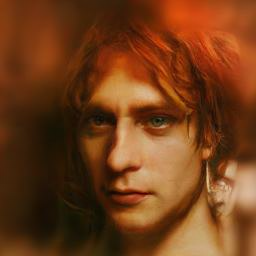

In [6]:
# 从google ddpm仓库中导入模型
image_pipe = DDPMPipeline.from_pretrained(
    "./ddpm-celebahq-256"
)
image_pipe.to(device)
images = image_pipe().images
images[0]

In [7]:
# 使用DDIM管道替代DDPM管道
from diffusers import DDIMPipeline,DDIMScheduler

In [8]:
scheduler = DDIMScheduler.from_pretrained(
    "./ddpm-celebahq-256"
)
scheduler.set_timesteps(num_inference_steps=40)

In [9]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

0it [00:00, ?it/s]

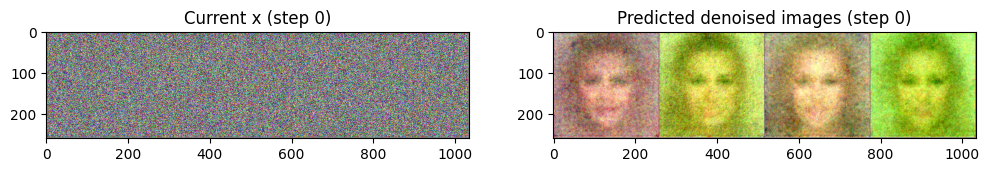

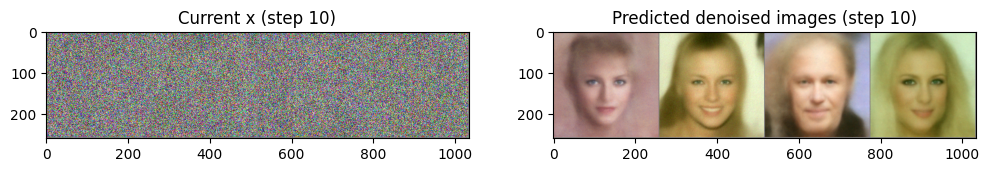

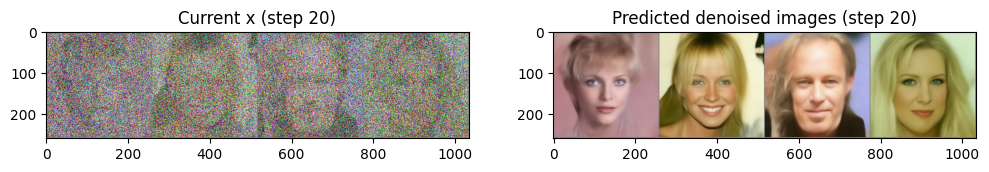

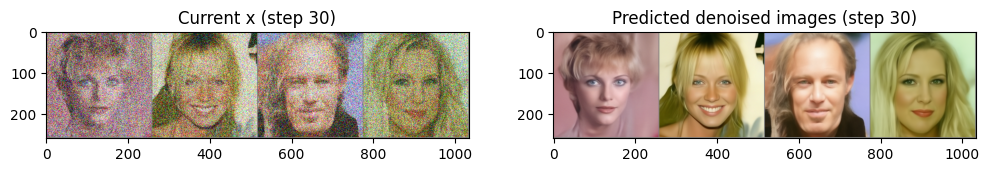

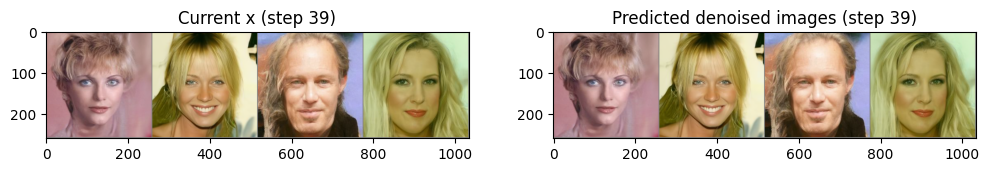

In [14]:
# 利用DDIM管道生成图片
x = torch.randn(4,3,256,256).to(device)

for i,t in tqdm(enumerate(scheduler.timesteps)):
    # 利用scale_model_input函数将时间步t扩充到模型输入中
    model_input = scheduler.scale_model_input(x,t)
    # 预测噪声
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input,t)['sample']
    # 使用调度器计算更新后的样本应该是什么样子
    scheduler_output = scheduler.step(noise_pred,t,x)

    # 更新输入图像
    x = scheduler_output.prev_sample
    # 定时观测去噪图片
    if i % 10 == 0 or i == len(scheduler.timesteps)-1:
        fig,axs = plt.subplots(1,2,figsize=(12,5))

        grid = torchvision.utils.make_grid(
            x,nrow=4).permute(1,2,0)
        axs[0].imshow(grid.cpu().clip(-1,1)*0.5+0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = (
            scheduler_output.pred_original_sample
        )
        grid = torchvision.utils.make_grid(
            pred_x0,nrow=4).permute(1,2,0)
        axs[1].imshow(grid.cpu().clip(-1,1)*0.5+0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

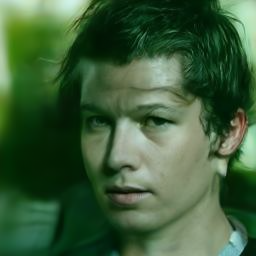

In [16]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]